In [19]:
import xyshear
import matplotlib.pyplot as plt
import pyccl as ccl
import numpy as np
import pickle
%matplotlib inline

In [30]:
cosmology = {
    "Omega_c": 0.26066676,
    "Omega_b": 0.048974682,
    "h": 0.6766,
    "sigma8": 0.8102,
    "n_s": 0.9665,
    "matter_power_spectrum": "halofit"
}
cosmo = ccl.Cosmology(**cosmology)
halo_mass_definition = ccl.halos.MassDef200c
halo_bias = ccl.halos.HaloBiasTinker10(mass_def=halo_mass_definition)
halo_mass = ccl.halos.MassFuncTinker08(mass_def=halo_mass_definition)

concentration = ccl.halos.ConcentrationDuffy08(mass_def=halo_mass_definition)

hm_calc = ccl.halos.HMCalculator(
    mass_function=halo_mass, 
    halo_bias=halo_bias,
    mass_def=halo_mass_definition,
    log10M_max=15.,
    log10M_min=10.,
    nM=32
)

k_arr = np.geomspace(1e-4, 1e2, 256)
lk_arr = np.log(k_arr)
a_arr = np.linspace(0.3, 1, 8)
zs = np.array([0, 1])

In [31]:
profile_parameters = {
    "lMc": 14.6,
    "gamma": 1.2
}

In [32]:
# Define profiles
profile_DM = ccl.halos.HaloProfileNFW(
    mass_def=halo_mass_definition, 
    concentration=concentration
)

profile_baryon = xyshear.HaloProfileNFWBaryon(
    mass_def=halo_mass_definition,
    concentration=concentration,
    **profile_parameters
)
profile_pressure = xyshear.HaloProfilePressureHE(
    mass_def=halo_mass_definition,
    concentration=concentration,
    kind="n_total",
    **profile_parameters
)
profile_density = xyshear.HaloProfileDensityHE(
    mass_def=halo_mass_definition,
    concentration=concentration,
    kind="n_total",
    **profile_parameters
)
J = pickle.load(
    open(
        f"../data/Jtot_Z0.30_Emin0.50_Emax2.00.pck",
        "rb"
    )
)
profile_Xray = xyshear.HaloProfileXray(
    mass_def=halo_mass_definition,
    Jinterp=J,
    dens=profile_density,
    pres=profile_pressure,
    fourier_approx=False,
    with_clumping=True
)

In [41]:
# Get p of k
pk_MM_NFWbar = ccl.halos.halomod_Pk2D(
    cosmo,
    hm_calc,
    profile_baryon,
    lk_arr=lk_arr,
    a_arr=a_arr
)

pk_MM_NFW = ccl.halos.halomod_Pk2D(
    cosmo,
    hm_calc,
    profile_DM,
    lk_arr=lk_arr,
    a_arr=a_arr

)

pk_MXray_NFWbar = ccl.halos.halomod_Pk2D(
    cosmo,
    hm_calc,
    profile_Xray,
    prof2=profile_baryon,
    lk_arr=lk_arr,
    a_arr=a_arr
)

pk_MXray_NFW = ccl.halos.halomod_Pk2D(
    cosmo,
    hm_calc,
    profile_Xray,
    prof2=profile_DM,
    lk_arr=lk_arr,
    a_arr=a_arr
)

pk_MPres_NFWbar = ccl.halos.halomod_Pk2D(
    cosmo,
    hm_calc,
    profile_pressure,
    prof2=profile_baryon,
    lk_arr=lk_arr,
    a_arr=a_arr
)

pk_MPres_NFW = ccl.halos.halomod_Pk2D(
    cosmo,
    hm_calc,
    profile_pressure,
    prof2=profile_DM,
    lk_arr=lk_arr,
    a_arr=a_arr
)

/mnt/users/alaposta/tSZ_shear_correlations/software_131023/xCell-likelihoods/papers/x_plus_y/xyshear/profiles.py:806: IntegrationWarning: The extrapolation table constructed for convergence acceleration
  of the series formed by the integral contributions over the cycles, 
  does not converge to within the requested accuracy.  Look at 
  info['ierlst'] with full_output=1.
  quad(
/mnt/users/alaposta/tSZ_shear_correlations/software_131023/xCell-likelihoods/papers/x_plus_y/xyshear/profiles.py:806: IntegrationWarning: Bad integrand behavior occurs within one or more of the cycles.
  Location and type of the difficulty involved can be determined from 
  the vector info['ierlist'] obtained with full_output=1.
  quad(
/mnt/users/alaposta/tSZ_shear_correlations/software_131023/xCell-likelihoods/papers/x_plus_y/xyshear/profiles.py:806: IntegrationWarning: The maximum number of cycles allowed has been achieved., e.e.
  of subintervals (a+(k-1)c, a+kc) where c = (2*int(abs(omega)+1))
  *pi/abs(o

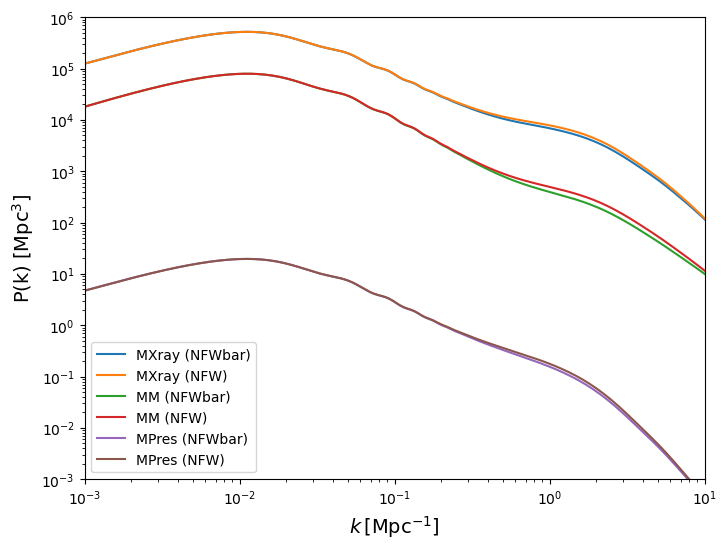

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(k_arr, pk_MXray_NFWbar(k_arr, 1.0), label="MXray (NFWbar)")
plt.plot(k_arr, pk_MXray_NFW(k_arr, 1.0), label="MXray (NFW)")
plt.plot(k_arr, pk_MM_NFWbar(k_arr, 1.0), label="MM (NFWbar)")
plt.plot(k_arr, pk_MM_NFW(k_arr, 1.0), label="MM (NFW)")
plt.plot(k_arr, pk_MPres_NFWbar(k_arr, 1.0), label="MPres (NFWbar)")
plt.plot(k_arr, pk_MPres_NFW(k_arr, 1.0), label="MPres (NFW)")
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-3, 1e1)
plt.ylim(1e-3, 1e6)
plt.legend()
plt.xlabel(r"$k\, [\mathrm{Mpc}^{-1}]$", fontsize=14)
plt.ylabel(r"P(k) [Mpc$^3$]", fontsize=14);